Ordinary Least Squares(최소자승추정법) 기반의 회귀 계수 계산은 변수들의 독립성에 많은 영향을 받음.
- 오차항이란 y를 x로 설명할 수 없는, 즉 예측할 수 없는 충격을 의미함.
- 회귀분석의 목표는 이 오차항의 크기를 감소 시키는 것.
- 오차항은 항상 양의 값을 가지는 것만이 아니기 때문에 오차항의 제곱의 합을 감소시키는 방법을 선택하게 되고, 이것이 OLS가 됨.

# 단순선형회귀
- 사이킷런에 내장된 보스턴 주택 가격 데이터를 이용

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

boston = load_boston()
bostonDF = pd.DataFrame(boston.data,columns=boston.feature_names)
bostonDF['PRICE'] = boston.target
print('boston 데이터 세트 크기:,',bostonDF.shape)
bostonDF.head()

boston 데이터 세트 크기:, (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


- CRIM: 지역별 범죄 발생률
- ZN: 25,000평방피트를 초과하는 거주 지역의 비율
- INDUS: 비상업 지역 넓이 비율
- CHAS: 강의 경계에 위치 했는지(했으면 0, 아니면 1)
- NOX: 일산화질소 농도
- RM: 거주할 수 있는 방 개수
- AGE: 1940년 이전에 건축된 소유 주택의 비율
- DIS: 5개 주요 고용센터까지의 가중 거리
- RAD: 고속도로 접근 용이도
- TAX: 10,000달러당 재산세율
- PTRATIO: 지역의 교사와 학생 수 비율
- B: 지역의 흑인 거주 비율
- LSTAT: 하위 계층의 비율
- MEDV: 본인 소유의 주택 가격(중앙값)

각 칼럼들이 PRICE값에 어떤 영향을 주는지 파악해보자.

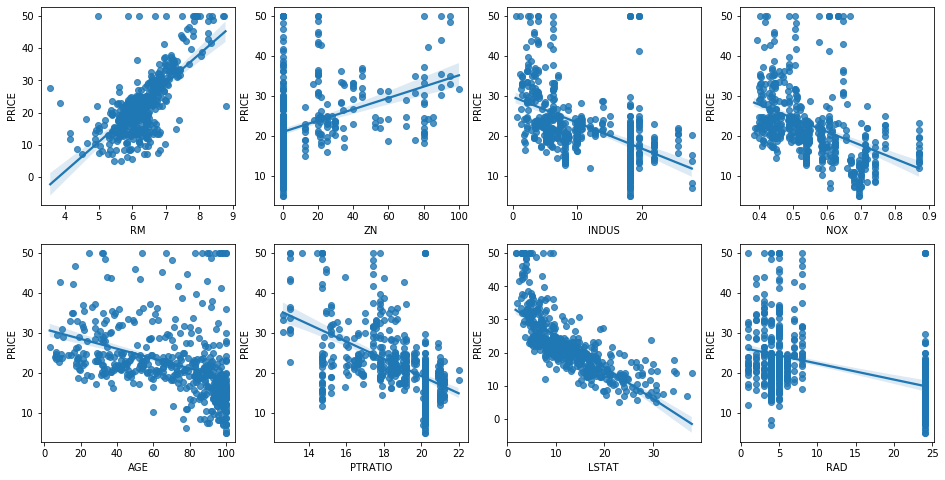

In [15]:
fig,axs = plt.subplots(figsize=(16,8),ncols=4,nrows=2)
lm_features = ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD']
for i, feature in enumerate(lm_features):
  row = int(i/4) # 반환값: 0,0,0,0,1,1,1,1
  col = i%4      # 반환값: 0,1,2,3,0,1,2,3
  
  sns.regplot(x=feature,y='PRICE',data=bostonDF,ax=axs[row][col])

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)

X_train,X_test,y_train,y_test = train_test_split(X_data,y_target,test_size=0.3,
                                                 random_state=156)

# 선형 회귀 OLS로 학습,예측,평가 수행.
lr = LinearRegression()
lr.fit(X_train,y_train)

y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test,y_preds)
rmse = np.sqrt(mse)
print('rmse:',rmse)
print('Train Variance score:',lr.score(X_train,y_train))
print('Test Variance score:',r2_score(y_test,y_preds)) #print('Variance score:',lr.score(X_test,y_test))

rmse: 4.1589561079556985
Train Variance score: 0.7273505005599823
Test Variance score: 0.7572263323138941


훈련 세트와 테스트 세트의 점수가 거의 비슷함(Train의 R2 score가 좀더 낮음).
- 이는 Underfitting을 의미함.
- 단순 선형회귀에서는 Overfitting을 걱정할 필요가 없음.

In [17]:
print('절편 값:',lr.intercept_)
print('회귀계수 값:',np.round(lr.coef_,1))

절편 값: 40.995595172164755
회귀계수 값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [18]:
coeff = pd.Series(data= np.round(lr.coef_,1),index=X_data.columns)
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
B           0.0
TAX        -0.0
AGE         0.0
INDUS       0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

cross_val_score()를 이용해 교차 검증으로 MSE와 RMSE를 측정해 보자.

In [19]:
from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)
lr = LinearRegression()

# cross_val_score() 로 폴드 세트로 MSE를 구한 뒤 이를 기반으로 다시 RMSE를 구함.
neg_mse_scores = cross_val_score(lr,X_data,y_target,scoring='neg_mean_squared_error',cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# cross_val_score(scoring='neg_mean_squared_error')로 반환된 값은 모두 음수
print('5 folds 의 개별 Negative MSE scores:',np.round(neg_mse_scores,2))
print('5 folds 의 개별 RMSE scores:',np.round(rmse_scores,2))
print('5 folds의 평균 RMSE:{0:.3f}'.format(avg_rmse))

5 folds 의 개별 Negative MSE scores: [-12.46 -26.05 -33.07 -80.76 -33.31]
5 folds 의 개별 RMSE scores: [3.53 5.1  5.75 8.99 5.77]
5 folds의 평균 RMSE:5.829


cross_val_score()함수를 사용하면 score값이 클수록 좋은 평가 결과로 자동 평가하기 때문에 음수로 반환하는 것을 알아두자. 그래서 음수 값으로 반환한 뒤 -1을 곱해주는 것이다.

---------------
데이터 수가 적은 경우에는 검증 데이터의 수도 적기 떄문에 검증 성능의 신뢰도가 떨어짐. 그렇다고 검증 데이터를 늘리면 정상적인 학습이 되지 않음.
- 이러한 딜레마를 해결하기 위해 K-Fold 교차검증 방법을 사용하는 것임.

---
선형 회귀는 매개변수가 없는 것이 장점이지만, 그래서 모댈의 복잡도를 제어할 방법도 없는 것이 단점이다.

# 다항 회귀(Polynomial Regressuion)
- 단순 선형 회귀는 독립변수와 종속변수의 관계가 일차 방정식 형태로 표현된 회귀이다.
- 회귀가 독립변수의 단항식이 아닌 2차, 3차 방정식과 같은 다항식으로 표현되는 것을 다항 회귀라고 함.
- **다항 회귀는 비선형 회귀가 아니다. 선형 회귀이다.**
- ★ 회귀에서 선형/비선형을 나누는 기준은 회귀계수가 선형/비선형인지에 따른 것이지, 독립변수의 선형/비선형과는 무관흠을 알아두자.

사이킷런은 다항회귀를 위한 클래스를 며이적으로 제공하지 않음.
- 비선형 함수를 선형 모델에 적용시키는 방법을 사용해 구현

In [20]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

#[[0,1],[2,3]]의 2*2 행렬 생성
X = np.arange(4).reshape(2,2)
print(X)

[[0 1]
 [2 3]]


PolynomialFeatures는 전처리를 위한 라이브러리(패키지)의 클래스이다.

In [21]:
# degree =2인 2차 다항식으로 변환하기 위해 PolynomialFeatures를 이용해 변환
poly = PolynomialFeatures(degree=2)
poly.fit(X)
poly_ftr = poly.transform(X)
# 1,X1,X2,X1^2,X1*X2,X2^2
poly_ftr

array([[1., 0., 1., 0., 0., 1.],
       [1., 2., 3., 4., 6., 9.]])

In [33]:
# 3차 다항식 값 반환
def polynomial_func(X):
  y = 1+2*X[:,0] + 3*X[:,0]**2 + 4*X[:,1]**3
  return y

X = np.arange(4).reshape(2,2)
print('일차 단항식 계수값:\n',X)
y = polynomial_func(X)
print('삼차 다항식 결정값:\n',y)

일차 단항식 계수값:
 [[0 1]
 [2 3]]
삼차 다항식 결정값:
 [  5 125]


일차 단항식 계수를 삼차 다항식 계수로 변환하고, 이를 이용해 선형 회귀에 적용하면 다항 회구로 구현된다.

In [37]:
print(X)
poly_ftr = PolynomialFeatures(degree=3).fit_transform(X)

print('3차 다항식 계수 feature:\n',poly_ftr)

[[0 1]
 [2 3]]
3차 다항식 계수 feature:
 [[ 1.  0.  1.  0.  0.  1.  0.  0.  0.  1.]
 [ 1.  2.  3.  4.  6.  9.  8. 12. 18. 27.]]


In [38]:
# 선형 회귀에 3차 다항식 계수 피처와 3차 다항식 결정값으로 학습 후 회귀 계수 확인
model = LinearRegression()
model.fit(poly_ftr,y)

print('Polynomial 회귀계수 \n',np.round(model.coef_,2))
print('Polynomial 회귀계수 Shape:',np.round(model.coef_.shape))

Polynomial 회귀계수 
 [0.   0.18 0.18 0.36 0.54 0.72 0.72 1.08 1.62 2.34]
Polynomial 회귀계수 Shape: [10]


## Pipeline 객체를 이용한 다항 회귀 구현

In [52]:
from sklearn.pipeline import Pipeline
def polynomial_func(X):
  y = 1+2*X[:,0] + 3*X[:,0]**2 + 4*X[:,1]**3
  return y

#Pipeline 객체로 간소하게 다항식 피처 변환과 선형 회귀를 연결
model = Pipeline([('poly',PolynomialFeatures(degree=3)), # 1번째 step
                  ('linear',LinearRegression())])       # 2번째 step
X = np.arange(4).reshape(2,2)
y = polynomial_func(X)

model = model.fit(X,y)
print('Polynomial 회귀 계수 \n',np.round(model.named_steps['linear'].coef_,2))

Polynomial 회귀 계수 
 [0.   0.18 0.18 0.36 0.54 0.72 0.72 1.08 1.62 2.34]


---
- 다항 회귀, Pipeline을 이용한 BostonDF 주택가격 예측

In [53]:
bostonDF.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [62]:
y_target = bostonDF['PRICE']
X_data = bostonDF.drop('PRICE',axis=1,inplace=False)

X_train,X_test,y_train,y_test = train_test_split(X_data,y_target,test_size=0.3,random_state=156)

## Pipeline을 이용한 PolynomialFeatures 변환과 LinearRegression 적용을 순차적으로 결합.
p_model = Pipeline([('poly',PolynomialFeatures(degree=2,include_bias=False)),
                    ('linear',LinearRegression())])

p_model.fit(X_train,y_train)
y_preds = p_model.predict(X_test)
mse = mean_squared_error(y_test,y_preds)
rmse = np.sqrt(mse)

print('MSE: {0:.3f},RMSE : {1:.3f}'.format(mse,rmse))
print('Variance score: {0:.3f}'.format(r2_score(y_test,y_preds)))

# 3차 다항식으로 증가시키면 어떻게 될까?
p_model = Pipeline([('poly',PolynomialFeatures(degree=3,include_bias=False)),
                    ('linear',LinearRegression())])

p_model.fit(X_train,y_train)
y_preds = p_model.predict(X_test)
mse = mean_squared_error(y_test,y_preds)
rmse = np.sqrt(mse)

print('MSE: {0:.3f},RMSE : {1:.3f}'.format(mse,rmse))
print('Variance score: {0:.3f}'.format(r2_score(y_test,y_preds)))

MSE: 15.556,RMSE : 3.944
Variance score: 0.782
MSE: 79625.595,RMSE : 282.180
Variance score: -1116.598


다항회귀의 주의할 점은 과적합이다.

In [63]:
X_train_poly = PolynomialFeatures(degree=2,include_bias=False).fit_transform(X_train,y_train)
X_train_poly.shape, X_train.shape

((354, 104), (354, 13))

다항 회귀를 쓸 때는 degree를 조절하는 것에 대해 극도히 유의해야한다.

# Unerfitting과 Overfitting
https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html

Automatically created module for IPython interactive environment


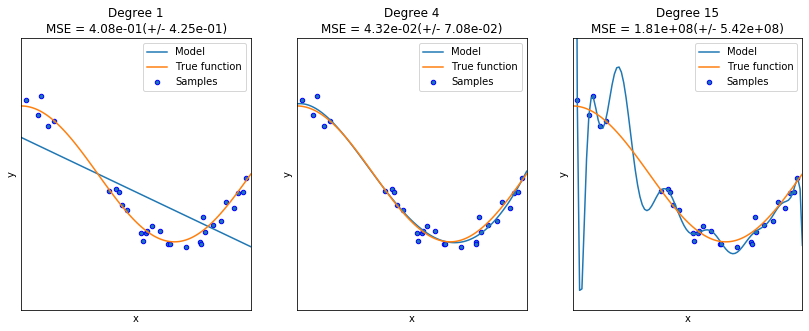

In [67]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test,true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()

## 편향-분산 트레이드오프(BIas-Variance Trade off)
-  회귀계수가 커질수록 Overfitting을 할 가능성이 높아진다.
- 과소적합: 편향이 크다는 것( 나는 이 길만 고집할 것이다, high Bias-Low Variance)
- 과대적합: 팔랑귀( 모든걸 다포함해야함,High Variance-Low Bias)

![대체 텍스트](https://lh3.googleusercontent.com/rq_iMVSuIK1K4ykF9RQnF05hH6xxWm3lmNPWuQ3hfK9r4-3GBIuCxCW3L7QH53M3EIwbVWOcaRiRLDc0AIJ-0uq8-qzavpSWPceQ1lchq-ZPF16l3KLst24-x6MbGYFqQbEJmEI3gEc)

<https://www.opentutorials.org/module/3653/22071>